In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
pd.options.display.float_format = '{:.5f}'.format

# 데이터 불러오기

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
car_2020 = pd.read_csv('data/car_2020.csv',encoding='cp949')
age = pd.read_csv('data/age_gender_info.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [96]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72000,134,38.00000,A,15667000,103680,0.00000,3.00000,1425.00000,1015.00000
1,C2483,900,아파트,경상북도,국민임대,39.72000,15,38.00000,A,15667000,103680,0.00000,3.00000,1425.00000,1015.00000
2,C2483,900,아파트,경상북도,국민임대,51.93000,385,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000
3,C2483,900,아파트,경상북도,국민임대,51.93000,15,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000
4,C2483,900,아파트,경상북도,국민임대,51.93000,41,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000


In [97]:
a = pd.qcut(train['총세대수'],3,labels=[1,2,3]) # 소단지,중단지,대단지
train.insert(14,'단지규모',a)

In [98]:
train['총세대수'] = np.log(train['총세대수'])

car_2020 = car_2020.drop(['시군구(1)'], axis=1)
car_2020.columns = ['지역','월','항목','분류','자동차수']
car_2020['월'] = pd.to_datetime(car_2020['월']).dt.month
car_2020.head()

In [99]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
단지규모                              0
등록차량수                             0
dtype: int64

In [100]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

pd.concat([train.자격유형.value_counts(),
           test.자격유형.value_counts()], axis=1)

,자격유형,자격유형
A,1801,573
D,569,180
국민임대/장기전세_공급대상,222,103
행복주택_공급대상,213,124
영구임대_공급대상,147,42


In [101]:
train_copy = train.copy()
train_copy = pd.get_dummies(train_copy,columns=['자격유형'])
del train_copy['등록차량수']
train_copy['등록차량수'] = train['등록차량수']
train = train_copy

In [102]:
train.head(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,단지규모,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,등록차량수
0,C2483,6.80239,아파트,경상북도,국민임대,39.72000,134,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,경상북도,국민임대,39.72000,15,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,경상북도,국민임대,51.93000,385,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
3,C2483,6.80239,아파트,경상북도,국민임대,51.93000,15,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
4,C2483,6.80239,아파트,경상북도,국민임대,51.93000,41,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000


# 컬럼명 바꿔주기

In [103]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '단지규모', 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택', '등록차량수'
]

In [104]:
train.head(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,등록차량수
0,C2483,6.80239,아파트,경상북도,국민임대,39.72000,134,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,경상북도,국민임대,39.72000,15,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,경상북도,국민임대,51.93000,385,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
3,C2483,6.80239,아파트,경상북도,국민임대,51.93000,15,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
4,C2483,6.80239,아파트,경상북도,국민임대,51.93000,41,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000


# 지하철 Y or N로 변경

In [105]:
train['지하철'] = train['지하철'].fillna(0)
train['지하철'] = np.where(train['지하철'] == 0, 0, 1)

# 결측치 처리

In [106]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
train.loc[train.임대료=='-', '임대료'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
train['임대료'] = train['임대료'].astype(float)
train['임대보증금'] = train['임대보증금'].fillna(0)
train['임대료'] = train['임대료'].fillna(0)

In [107]:
train['버스'] = train['버스'].fillna(train['버스'].mean())

In [108]:
train.isnull().sum()

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
임대보증금        0
임대료          0
지하철          0
버스           0
단지내주차면수      0
단지규모         0
A            0
D            0
국민임대/장기전세    0
영구임대         0
행복주택         0
등록차량수        0
dtype: int64

# 임대건물구분 : 아파트->상가 / 전용면적별세대수 : x->1

In [109]:
idx = train[(train['임대건물구분']=='아파트') & (train['D']=='D')]['전용면적별세대수'].index
train.loc[idx, '전용면적별세대수'] = 1
train.loc[idx, '임대건물구분'] = '상가'

In [110]:
# 원핫 인코딩
#train = pd.get_dummies(data = train, columns = ['지하철'])

# 지역명 숫자로 매핑

In [111]:
local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i
    
train['지역'] = train['지역'].map(local_map)

# 전용면적을 5의 배수로 변경

In [112]:
train['전용면적'] = train['전용면적']//5*5

# 전용면적 상/하한 적용

In [113]:
idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index
train.loc[idx, '전용면적'] = 15

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   단지코드       2952 non-null   object  
 1   총세대수       2952 non-null   float64 
 2   임대건물구분     2952 non-null   object  
 3   지역         2952 non-null   int64   
 4   공급유형       2952 non-null   object  
 5   전용면적       2952 non-null   float64 
 6   전용면적별세대수   2952 non-null   int64   
 7   공가수        2952 non-null   float64 
 8   임대보증금      2952 non-null   float64 
 9   임대료        2952 non-null   float64 
 10  지하철        2952 non-null   int32   
 11  버스         2952 non-null   float64 
 12  단지내주차면수    2952 non-null   float64 
 13  단지규모       2952 non-null   category
 14  A          2952 non-null   uint8   
 15  D          2952 non-null   uint8   
 16  국민임대/장기전세  2952 non-null   uint8   
 17  영구임대       2952 non-null   uint8   
 18  행복주택       2952 non-null   uint8   
 19  등록차량수      2952 non-null   

# test 불러오기

In [115]:
a = pd.qcut(test['총세대수'],3,labels=[1,2,3]) # 소단지,중단지,대단지
test.insert(14,'단지규모',a)

In [116]:
test_copy = test.copy()
test_copy = pd.get_dummies(test_copy,columns=['자격유형'])
test = test_copy

In [117]:
test

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,단지규모,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
0,C1072,754,아파트,경기도,국민임대,39.79000,116,14.00000,22830000,189840,0.00000,2.00000,683.00000,2,0,0,1,0,0
1,C1072,754,아파트,경기도,국민임대,46.81000,30,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,1,0,0,0,0
2,C1072,754,아파트,경기도,국민임대,46.90000,112,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,0,0,1,0,0
3,C1072,754,아파트,경기도,국민임대,46.90000,120,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,0,0,1,0,0
4,C1072,754,아파트,경기도,국민임대,51.46000,60,14.00000,43497000,296780,0.00000,2.00000,683.00000,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,C1267,675,아파트,경상남도,행복주택,36.77000,126,38.00000,-,-,0.00000,1.00000,467.00000,2,0,0,0,0,1
1018,C2189,382,아파트,전라북도,국민임대,29.19000,96,45.00000,6872000,106400,0.00000,2.00000,300.00000,1,0,0,1,0,0
1019,C2189,382,아파트,전라북도,국민임대,29.19000,20,45.00000,6872000,106400,0.00000,2.00000,300.00000,1,0,0,1,0,0
1020,C2189,382,아파트,전라북도,국민임대,39.45000,202,45.00000,13410000,144600,0.00000,2.00000,300.00000,1,0,0,1,0,0


In [118]:
test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '단지규모' , 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택'
]

In [119]:
test.isnull().sum()

단지코드           0
총세대수           0
임대건물구분         0
지역             0
공급유형           0
전용면적           0
전용면적별세대수       0
공가수            0
임대보증금        180
임대료          180
지하철           42
버스             0
단지내주차면수        0
단지규모           0
A              0
D              0
국민임대/장기전세      0
영구임대           0
행복주택           0
dtype: int64

In [120]:
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
test['임대보증금'] = test['임대보증금'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)
test['임대보증금'] = test['임대보증금'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [121]:
test['지하철'].value_counts()

0.00000    881
1.00000     64
2.00000     35
Name: 지하철, dtype: int64

In [122]:
test['지하철'] = test['지하철'].fillna(0)
test['지하철'] = np.where(test['지하철'] == 0, 0, 1)

In [123]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택
0,C1072,754,아파트,경기도,국민임대,39.79000,116,14.00000,22830000.00000,189840.00000,0,2.00000,683.00000,2,0,0,1,0,0
1,C1072,754,아파트,경기도,국민임대,46.81000,30,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,1,0,0,0,0
2,C1072,754,아파트,경기도,국민임대,46.90000,112,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,0,0,1,0,0
3,C1072,754,아파트,경기도,국민임대,46.90000,120,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,0,0,1,0,0
4,C1072,754,아파트,경기도,국민임대,51.46000,60,14.00000,43497000.00000,296780.00000,0,2.00000,683.00000,2,0,0,1,0,0


In [124]:
local_map = {}
for i, loc in enumerate(test['지역'].unique()):
    local_map[loc] = i
    
test['지역'] = test['지역'].map(local_map)

In [125]:
test['전용면적'] = test['전용면적']//5*5

idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

In [126]:
test.isnull().sum()

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
임대보증금        0
임대료          0
지하철          0
버스           0
단지내주차면수      0
단지규모         0
A            0
D            0
국민임대/장기전세    0
영구임대         0
행복주택         0
dtype: int64

In [127]:
columns = ['총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '단지규모', 
           'A', 'D', '국민임대/장기전세', '영구임대', '행복주택']
# columns = ['총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '단지규모']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')

In [128]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [129]:
new_train['임대보증금'] = 0
new_train['임대료'] = 0
new_test['임대보증금'] = 0
new_test['임대료'] = 0

## 수정한 코드

In [130]:
# Train Dataframe Set
# 미사용 열s - 임대건물구분, 공급유형, 자격유형 임대보증금, 임대료
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0]) # index 재설정
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col] # Fixed Data
    
    deposit_cost = []
    rental_cost = []

    for col in area_columns:
        area = float(col.split('_')[-1]) # 면적의 숫자를 float형으로 저장
        # '면적_10' 등의 열을 만들고 - 같은 전용면적들 끼리 전용면적별세대수의 합을 Value로 Cell에 입력
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
        
        try:
          deposit_cost.append(temp[temp['전용면적']==area]['임대보증금'][0])
          rental_cost.append(temp[temp['전용면적']==area]['임대료'][0])
        except KeyError as e:
          continue
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    # print(type(deposit_cost[0]))
    new_train.loc[i, '임대보증금'] = int(np.mean(deposit_cost))
    new_train.loc[i, '임대료'] = int(np.mean(rental_cost))

# Test DataFrame Set
# 미사용 열s - 임대건물구분, 공급유형, 자격유형 임대보증금, 임대료, 등록차량수
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]

    deposit_cost = []
    rental_cost = []
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
        
        try:
          deposit_cost.append(temp[temp['전용면적']==area]['임대보증금'][0])
          rental_cost.append(temp[temp['전용면적']==area]['임대료'][0])
        except KeyError as e:
          continue
          
    new_test.loc[i, '임대보증금'] = int(np.mean(deposit_cost))
    new_test.loc[i, '임대료'] = int(np.mean(rental_cost))


# 추가해볼 것 임대보증금 , 임대료 Column 만들고 평균

423it [00:08, 47.75it/s]
150it [00:03, 48.42it/s]


In [131]:
x_train = new_train.iloc[:, :-1]
y_train = new_train.iloc[:,-1]
x_test = new_test

In [132]:
pd.set_option('max_columns', 30)
x_train

,임대보증금,임대료,총세대수,지역,전용면적별세대수,공가수,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,면적_35.0,면적_50.0,면적_55.0,면적_30.0,면적_45.0,면적_40.0,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0
0,15667000.00000,103680.00000,6.80239,0.00000,134.00000,38.00000,0.00000,3.00000,1425.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,149.00000,665.00000,86.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,9216000.00000,82940.00000,6.30079,1.00000,276.00000,17.00000,0.00000,3.00000,624.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,80.00000,132.00000,0.00000,276.00000,57.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,15620000.00000,127350.00000,7.10332,2.00000,288.00000,13.00000,1.00000,1.00000,1285.00000,3.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,124.00000,0.00000,390.00000,340.00000,362.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,15607000.00000,130070.00000,6.62672,3.00000,120.00000,6.00000,1.00000,3.00000,734.00000,2.00000,0.00000,0.00000,1.00000,0.00000,0.00000,240.00000,303.00000,212.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,12015000.00000,102130.00000,6.54535,4.00000,228.00000,14.00000,0.00000,2.00000,645.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,254.00000,246.00000,0.00000,0.00000,196.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,16800000.00000,71400.00000,4.49981,9.00000,12.00000,7.00000,0.00000,3.00000,66.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,36.00000,0.00000,0.00000,0.00000,0.00000,0.00000,42.00000,0.00000,12.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
419,10000000.00000,117000.00000,6.19848,5.00000,132.00000,24.00000,0.00000,1.00000,521.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,156.00000,0.00000,0.00000,0.00000,180.00000,0.00000,156.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
420,18000000.00000,87000.00000,3.68888,8.00000,20.00000,7.00000,1.00000,2.00000,25.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,15.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.00000,20.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
421,10346000.00000,107530.00000,4.49981,11.00000,90.00000,12.00000,0.00000,1.00000,30.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,90.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [133]:
x_test

,임대보증금,임대료,총세대수,지역,전용면적별세대수,공가수,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,면적_35.0,면적_50.0,면적_55.0,면적_30.0,면적_45.0,면적_40.0,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0
0,22830000.00000,189840.00000,754.00000,0.00000,116.00000,14.00000,0.00000,2.00000,683.00000,2.00000,0.00000,0.00000,1.00000,0.00000,0.00000,116.00000,376.00000,0.00000,0.00000,262.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,22830000.00000,189840.00000,1354.00000,0.00000,368.00000,9.00000,0.00000,3.00000,1216.00000,3.00000,0.00000,0.00000,1.00000,0.00000,0.00000,420.00000,578.00000,0.00000,0.00000,356.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,19706000.00000,156200.00000,619.00000,1.00000,82.00000,18.00000,0.00000,16.00000,547.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,165.00000,132.00000,44.00000,82.00000,196.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,14418000.00000,108130.00000,593.00000,2.00000,253.00000,7.00000,0.00000,3.00000,543.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,335.00000,84.00000,0.00000,0.00000,174.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,28598000.00000,203050.00000,1297.00000,0.00000,282.00000,11.00000,0.00000,2.00000,1112.00000,3.00000,0.00000,0.00000,1.00000,0.00000,0.00000,425.00000,304.00000,0.00000,0.00000,568.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,6992000.00000,117000.00000,349.00000,6.00000,24.00000,17.00000,0.00000,4.00000,270.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,138.00000,0.00000,0.00000,0.00000,96.00000,0.00000,112.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
146,8084000.00000,149910.00000,596.00000,10.00000,164.00000,35.00000,0.00000,1.00000,593.00000,2.00000,0.00000,0.00000,1.00000,0.00000,0.00000,304.00000,0.00000,0.00000,0.00000,107.00000,0.00000,180.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
147,0.00000,0.00000,120.00000,7.00000,66.00000,9.00000,0.00000,1.00000,40.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,54.00000,0.00000,0.00000,0.00000,0.00000,0.00000,66.00000,0.00000,0.00000,0.00000,0.00000,0.00000
148,6882000.00000,104370.00000,675.00000,3.00000,28.00000,38.00000,0.00000,1.00000,467.00000,2.00000,0.00000,0.00000,1.00000,0.00000,0.00000,126.00000,0.00000,0.00000,0.00000,180.00000,0.00000,74.00000,0.00000,50.00000,240.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [134]:
forest = RandomForestRegressor(n_jobs=-1, random_state=42)
forest.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [135]:
pred = forest.predict(x_test)

In [136]:
submission['num'] = pred

In [137]:
# submission.to_csv('./신분OneHot.csv', index=False)

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x = new_train.iloc[:, :-1]
y = new_train.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
forest = RandomForestRegressor(random_state=0)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
mean_absolute_error(y_test, pred)

132.36037735849055

In [139]:
# 단지코드 포함 | 신분 One-Hot 포함 : 132.36037735849055
# 단지코드 포함 | 신분 One-Hot 제외 : 131.0185849056604

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

In [149]:
new_train.columns

Index(['임대보증금', '임대료', '총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수',
       '단지규모', 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택', '면적_35.0', '면적_50.0',
       '면적_55.0', '면적_30.0', '면적_45.0', '면적_40.0', '면적_25.0', '면적_70.0',
       '면적_15.0', '면적_20.0', '면적_100.0', '면적_60.0', '면적_75.0', '면적_80.0',
       '면적_65.0', '등록차량수'],
      dtype='object')

C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a pe

C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a pe

C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a pe

C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a pe

C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a pe

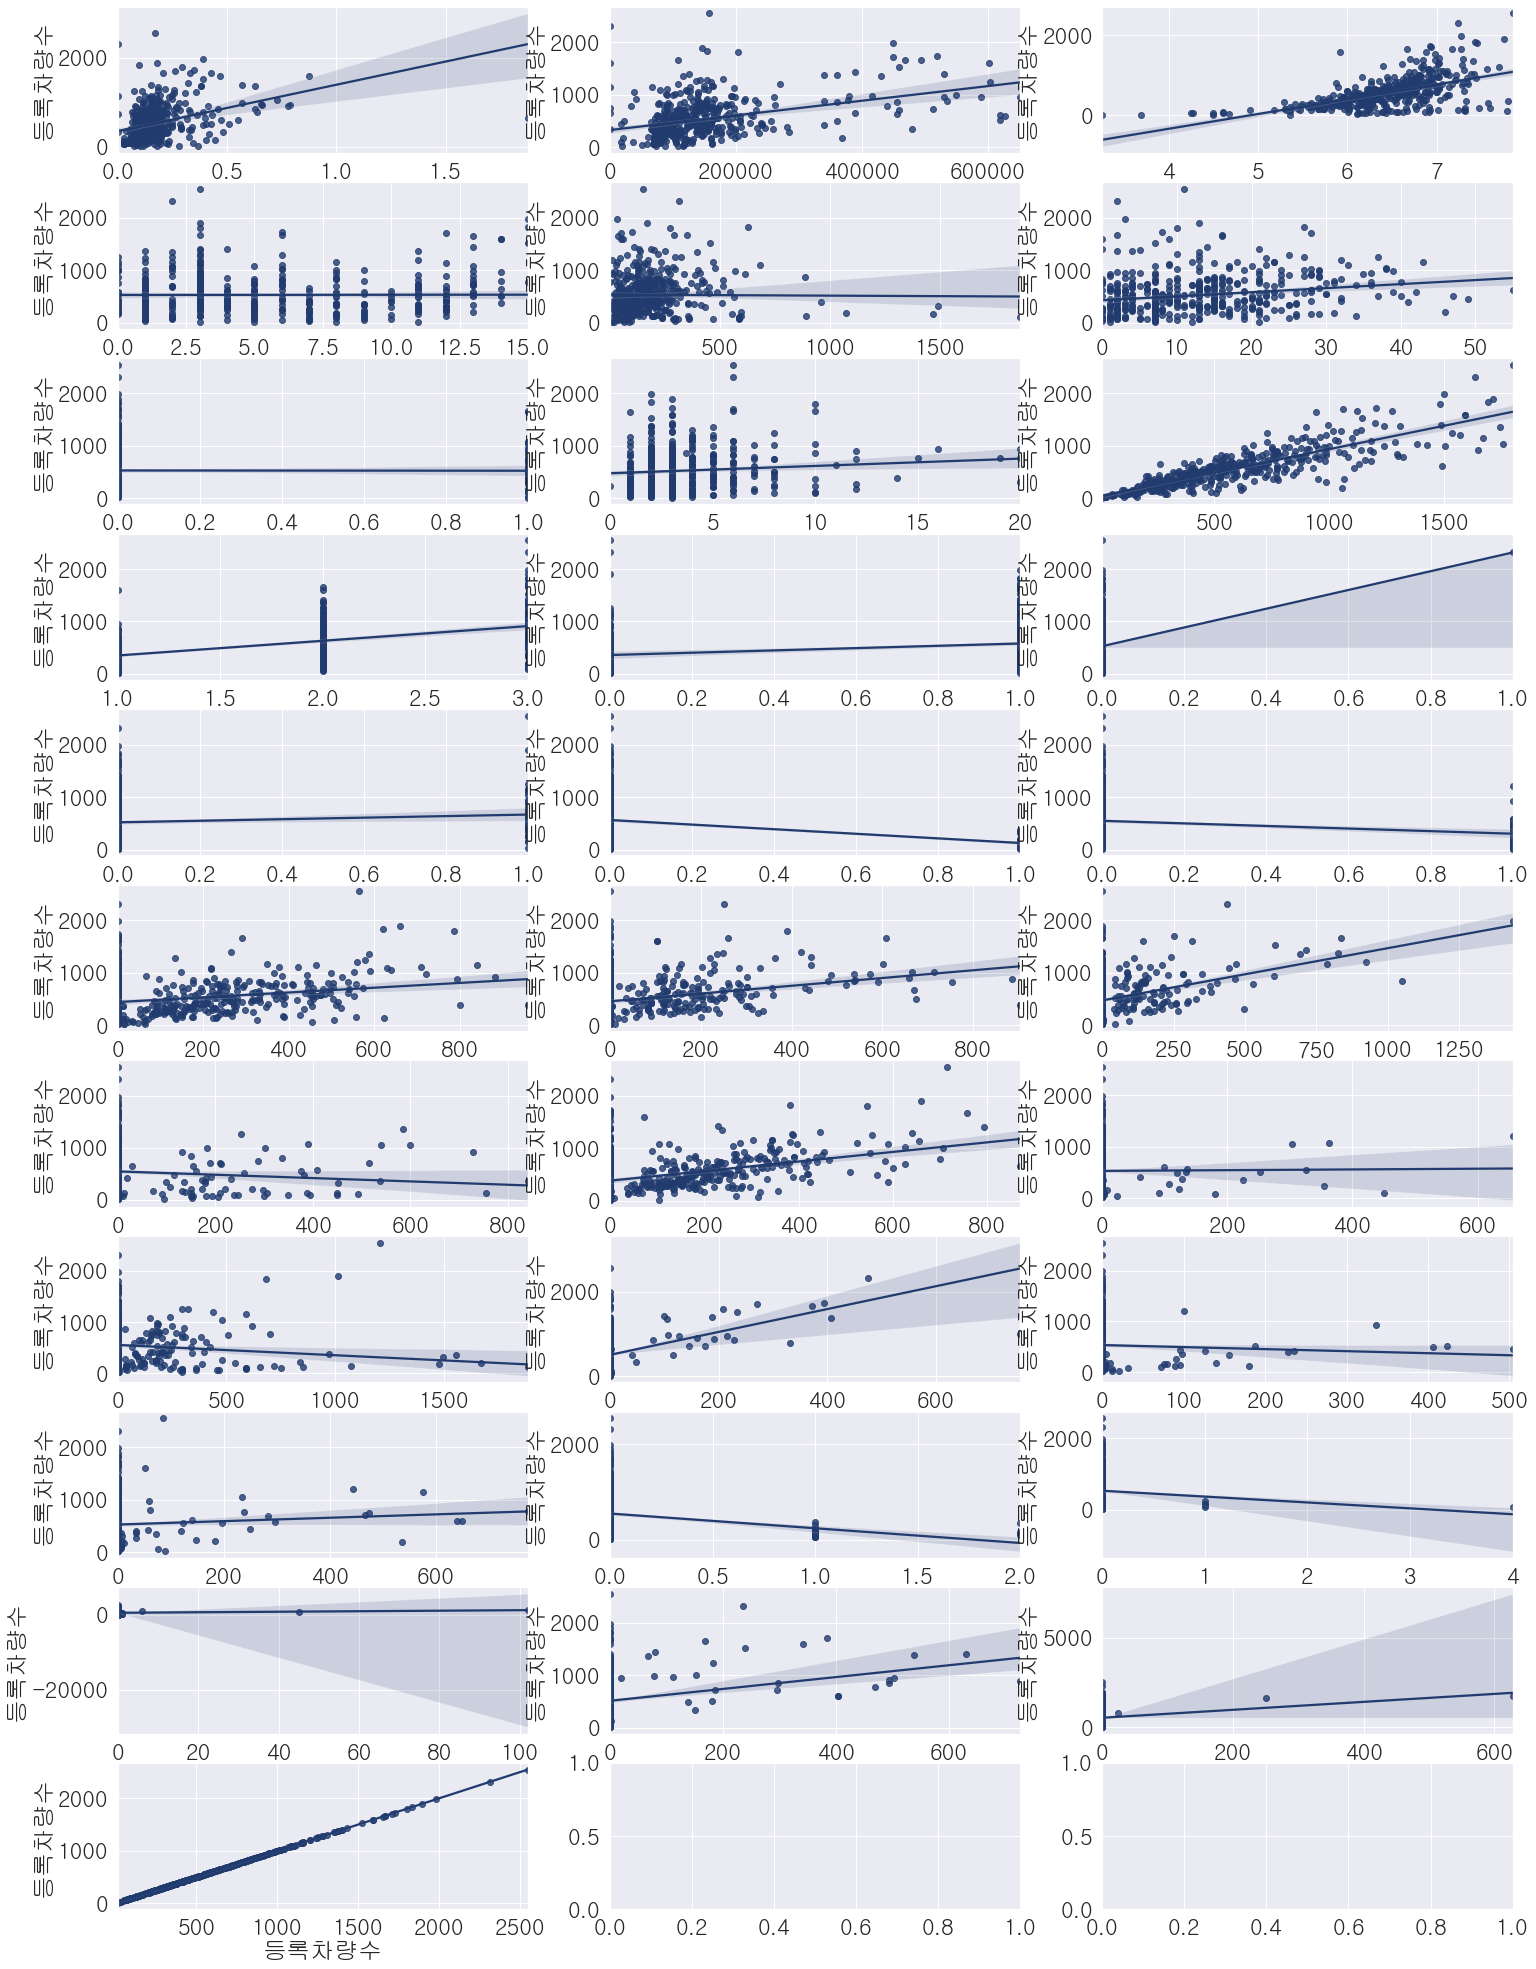

In [160]:
fig, ax = plt.subplots(11, 3, figsize=(25, 35))

for i, feature in enumerate(new_train.columns):
    row = int( i // 3 )
    col = i % 3
    
    sns.set_theme(style='darkgrid', palette='cividis', font='gulim', font_scale=2)
    sns.regplot(data=new_train, x=feature, y='등록차량수', ax=ax[row][col], robust=True)

In [161]:
for i, feature in enumerate(new_train.columns):
    print(f'{i} - {feature}')

0 - 임대보증금
1 - 임대료
2 - 총세대수
3 - 지역
4 - 전용면적별세대수
5 - 공가수
6 - 지하철
7 - 버스
8 - 단지내주차면수
9 - 단지규모
10 - A
11 - D
12 - 국민임대/장기전세
13 - 영구임대
14 - 행복주택
15 - 면적_35.0
16 - 면적_50.0
17 - 면적_55.0
18 - 면적_30.0
19 - 면적_45.0
20 - 면적_40.0
21 - 면적_25.0
22 - 면적_70.0
23 - 면적_15.0
24 - 면적_20.0
25 - 면적_100.0
26 - 면적_60.0
27 - 면적_75.0
28 - 면적_80.0
29 - 면적_65.0
30 - 등록차량수
